In [6]:
# Version 2.1 - new PN Activity representation (binomial dist.)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import pickle
import scipy.stats as st
import copy

# read csv 
df = pd.read_csv('connectivity matrix table 1.csv') # matrix of connections between neurons

# FUNCTIONS

# Filters dataframe based on neuron type. 
# Establishes a synapse threshold of greater than 1
# data - the dataframe
# col_substr - regex to select for substrings that represent neuron type in columns
# row_substr - regex to select for substrings that represent neuron type in rows
# row_header - header for indices
def filter_neuron_types(data, col_substr, row_substr, idx_header):
    first_column = df.iloc[:, 0] # gets first column to use as row indices
    # columns
    new_df = data.filter(regex=col_substr, axis='columns') 
    
    # rows
    new_df.insert(0, idx_header, first_column, True) # inserts column with row labels into the new dataframe
    new_df.set_index(idx_header, inplace=True) # sets inserted column as dataframe indicies
    new_df = new_df.filter(regex=row_substr, axis='index')
    
    # establishing a threshold of num synapses > 1 to count as a connection
    num_rows = len(new_df)
    # loops thru rows of new_df
    for i in range(num_rows):
        row = new_df.iloc[i] # gets row
        new_row = np.where(row == 1, 0, row) # if synaspse num = 1, change to 0
        new_df.iloc[i] = new_row
    
    return new_df

# Normalizes weights by column's sum in a pandas df
# df - dataframe
# sum_of_w - the sum of the weights
def normalize_weights_df(df, sum_of_w):
    col = len(df.columns)
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = df.iloc[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            df.iloc[:,c] = [i/s for i in w]
    return sum_of_w * df

# Normalizes weights by column's sum in a numpy array
# arr - numpy array
# sum_of_w - the sum of the weights
def normalize_weights_np(arr, sum_of_w):
    col = len(arr[0])
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = arr[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            arr[:,c] = [i/s for i in w]
    return sum_of_w * arr

# normalizes weights by the row's sum in a pandas df
def normalize_kc_weights_df(df, sum_of_w):
    row = len(df.index)
    for r in range(row):
        w = df.iloc[r]
        s = sum(abs(w)) # sum of row
        if (s != 0):
            df.iloc[r] = [i/s for i in w]
    return sum_of_w * df

# normalizes weights by the row's sum in a numpy array
def normalize_kc_weights_np(arr, sum_of_w):
    row = len(arr)
    for r in range(row):
        w = arr[r]
        s = sum(abs(w)) # sum of row
        if (s != 0):
            arr[r] = [i/s for i in w]
    return sum_of_w * arr

# Sets the bias for a single KC so that the KC fires 5% of 
# the time in response to any odor
# inputs - array of all points from all odors
# weights - array of weights (aka synapses) for a single KC
def set_kc_bias(inputs, weights):
    I = len(inputs)
    bias = 0
    
    kc_output = np.zeros((I,)) # array to store output values
    
    # loops thru all inputs and calculates and stores the KC output value
    for i in range(I):
        point = inputs[i]
        #print("point:\n{}, length: {}".format(point, len(point)))

        # equation
        x = np.dot(point, weights) # no bias yet (theta=0)
        #print("output value: {}".format(x))

        kc_output[i] = x  # add output value to output array
    
    kc_output.sort() # sort output values in ascending order
    #print("output values of single KC after sorting:\n{} \nlength: {}".format(kc_output, len(kc_output)))
    idx = int(0.05 * len(kc_output)) # getting index for the threshold that'll provide a 5% firing rate (out of 5000, this is the 251th output value with index of 250)
    #print("index: ", idx)
    bias = kc_output[idx]
    #print("bias: ", bias)
    
    return bias

# Calculates output of KC layer
# weights - weights (num of synapses) for connections from PNs to KCs
# biases - biases
# inputs - inputs from PNs
def build_pn_to_kc(inputs, weights, biases):
    
    # equation
    x1 = np.dot(inputs, weights) + biases # matrix multiplication to multiply inputs by weights
    #print("after matrix multiplication:\n{}, \nlength: {}".format(x1, len(x1)))

    # thresholding
    x1 = np.where(x1 > 0, 1, 0)
    #print("after thresholding:\n{}, \nlength: {}".format(x1, len(x1)))
    
    return x1

# Calculates output of MBON layer
# weights - weights (num of synapses) from KC to MBON
# inputs - inputs from KCs
# bias - biases
def build_kc_to_mbon(inputs, weights, bias):
    
    # equation
    x2 = np.dot(inputs, weights) + bias
    #print("after matrix multiplication:\n{}, \nnum of rows: {}".format(x2, len(x2)))

    # thresholding
    x2 = np.where(x2 > 0, 1, 0)
    #print("after thresholding:\n{}, \nlength: {}".format(x2, len(x2)))
    
    return x2

# Randomly prunes a certain number of pre-synaptic KCs and returns the new weight table (df) and the names of KCs with
# connections set to zero in each MBON
# df - synapse table
# num - number of KCs to remove
def prune_rand_kcs(df, num):
    num_mbons = len(df.columns)
    kc_names = []
    
    # loop thru each column = MBON
    for m in range(num_mbons):        
        idxs_with_conn = np.asarray(np.where(df.iloc[:,m] > 0)).flatten() # gets indicies where there is a connection to a KC
        
        # randomly select KC connections to be removed
        s = num
        if (len(idxs_with_conn) < num): # if less KC connections than num to remove, then remove all 
            s = len(idxs_with_conn)
        indicies = np.random.choice(a=idxs_with_conn, size=s, replace=False)
        
        kc_names.append(df.index[indicies]) # record names of KCs
        
        for i in indicies:
            df.iloc[i, m] = 0
    
    df = df.to_numpy()
    return df, kc_names

# Randomly ablates a certain number of pre-synaptic KCs and returns the new weight table (df) and the names of KCs with
# connections set to zero in each MBON
# df - synapse table
# num - number of KCs to remove
def ablate_rand_kcs(df, num):
    num_mbons = len(df.columns)
    num_kcs = len(df)
    kc_names = []    
        
    # randomly select KC connections to be removed
    indicies = random.choice(num_kcs, size=num, replace=False)
    kc_names.append(df.index[indicies]) # record names of KCs
    # sets each row (= each KC) in indices to zero
    for i in indicies:
        df.iloc[i, :] = 0
    
    df = df.to_numpy()
    return df, kc_names

# Sets the all synaptic weight values of the top certain number of KCs to zero. Returns new weight table with
# KCs removed and a list of names of the KCs removed
# prev_w - weight table from previous run (np arr)
# curr_w - current weight table (df as input, return as np array)
# num - the number of KCs' connections to remove
# run - the realization (eg. 0, 1, 2...)
def ablate_top_kcs(prev_w, curr_w, num, run):
    sum_weights = abs(prev_w[run]).sum(axis=1) # total absolute value of final weights for each KC 
    top_weight_idx = np.argpartition(sum_weights, -1*num)[-1*num:]
    
    # record which KCs are removed
    kc_names = list(curr_w.index[top_weight_idx])
    
    curr_w = curr_w.to_numpy()
    curr_w[top_weight_idx,:] = 0 # sets weight values of KCs to be removed to zero
    
    return curr_w, kc_names

In [13]:
# FILTER DATA FOR PNs (rows) to KCs (columns) CONNECTIONS -> pn_kc
pn_kc = filter_neuron_types(df, "(?=.*KC)(?=.*left)", "(?=.*PN)(?=.*left)", "Presynaptic PNs") # filter w/ regex PNs and KCs

# normalize weights
pn_kc = normalize_kc_weights_df(pn_kc, 1)
#pn_kc = pn_kc.fillna(0)

pn_kc

,1 claw KC left,1 claw KC left.1,1 claw KC left.2,1 claw KC left.3,1 claw KC left.4,1 claw KC left.5,1 claw KC left.6,1 claw KC left.7,1 claw KC left.8,1 claw KC left.9,...,young KC left.27,young KC left.28,young KC left.29,young KC left.30,young KC left.31,young KC left.32,young KC left.33,young KC left.34,young KC left.35,young KC left.36
Presynaptic PNs,,,,,,,,,,,,,,,,,,,,,
1a PN left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.024691,...,0,0,0,0.00000,0.000000,0.024691,0,0.00000,0.000000,0
13a PN left,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0,0,0.03125,0.000000,0.000000,0,0.00000,0.000000,0
22c PN left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0,0,0.00000,0.000000,0.000000,0,0.00000,0.000000,0
24a PN left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0,0,0.00000,0.000000,0.000000,0,0.00000,0.000000,0
30a PN left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0,0,0.00000,0.000000,0.000000,0,0.00000,0.000000,0
33a PN left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0,0,0.00000,0.000000,0.000000,0,0.00000,0.000000,0
35a PN bilateral left,0.000000,0.000000,0.000000,0.000000,0.361702,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0,0,0.00000,0.000000,0.000000,0,0.00000,0.000000,0
42a PN left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0,0,0.00000,0.000000,0.000000,0,0.00000,0.000000,0
42b PN left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0,0,0,0.00000,0.000000,0.000000,0,0.00000,0.000000,0


In [14]:
# FILTER DATA FOR KCs TO MBONs CONNECTIONS -> kc_to_mbon
kc_mbon = filter_neuron_types(df, "(?=.*MBON)(?=.*left)", "(?=.*KC)(?=.*left)", "Presynaptic KCs") # filter w/ regex for KCs and MBON lefts

# take out MBONs with no KC connections
kc_mbon = kc_mbon.drop(kc_mbon.loc[:, (kc_mbon.sum(axis=0) == 0)], axis=1)

# adding a fictional MBON
fict_weights = np.full(len(kc_mbon), 0.1) # initializing all weights at 0.1
kc_mbon['MBON-fict'] = fict_weights

# normalizing weights
kc_mbon = kc_mbon.fillna(0)
kc_mbon_orig = kc_mbon.copy(deep=True)
kc_mbon = normalize_kc_weights_df(kc_mbon, 1)

kc_mbon

,MBON-a1 left,MBON-a2 left,MBON-b1 left,MBON-b2 left,MBON-c1 left,MBON-d1 left,MBON-e1 left,MBON-e2 left,MBON-g1 left,MBON-g2 left,MBON-h1 left,MBON-h2 left,MBON-i1 left,MBON-k1 left,MBON-m1 left,MBON-n1 left,MBON-o1 left,MBON-q1 left,MBON-fict
Presynaptic KCs,,,,,,,,,,,,,,,,,,,
1 claw KC left,0.025141,0.031427,0.081710,0.043997,0.251414,0.062854,0.131992,0.043997,0.050283,0.043997,0.037712,0.062854,0.056568,0.000000,0.031427,0.0,0.012571,0.031427,0.000629
1 claw KC left,0.055134,0.027567,0.103377,0.103377,0.186079,0.089593,0.117161,0.020675,0.110269,0.075810,0.013784,0.048243,0.034459,0.000000,0.000000,0.0,0.013784,0.000000,0.000689
1 claw KC left,0.068446,0.027379,0.068446,0.095825,0.150582,0.061602,0.082136,0.027379,0.075291,0.061602,0.041068,0.061602,0.068446,0.020534,0.013689,0.0,0.013689,0.061602,0.000684
1 claw KC left,0.060740,0.027609,0.132523,0.110436,0.215351,0.049696,0.104914,0.033131,0.071784,0.022087,0.038653,0.077305,0.027609,0.000000,0.016565,0.0,0.000000,0.011044,0.000552
1 claw KC left,0.018171,0.018171,0.072683,0.048455,0.381587,0.084797,0.048455,0.000000,0.024228,0.066626,0.054512,0.042399,0.030285,0.012114,0.030285,0.0,0.000000,0.066626,0.000606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young KC left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
young KC left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
young KC left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000


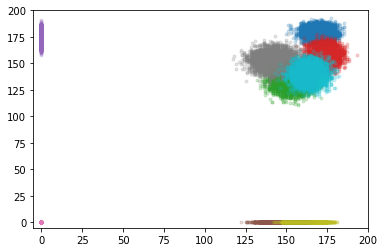

Realization 1: DONE


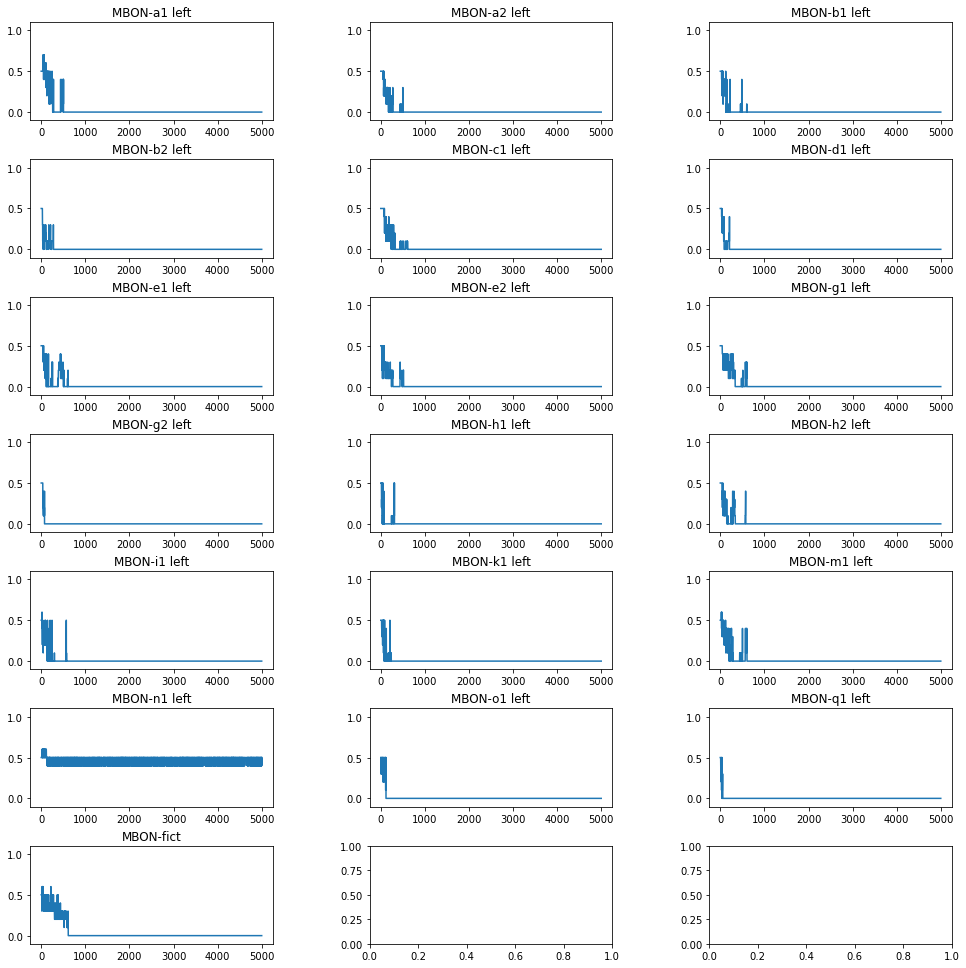

Realization 2: DONE


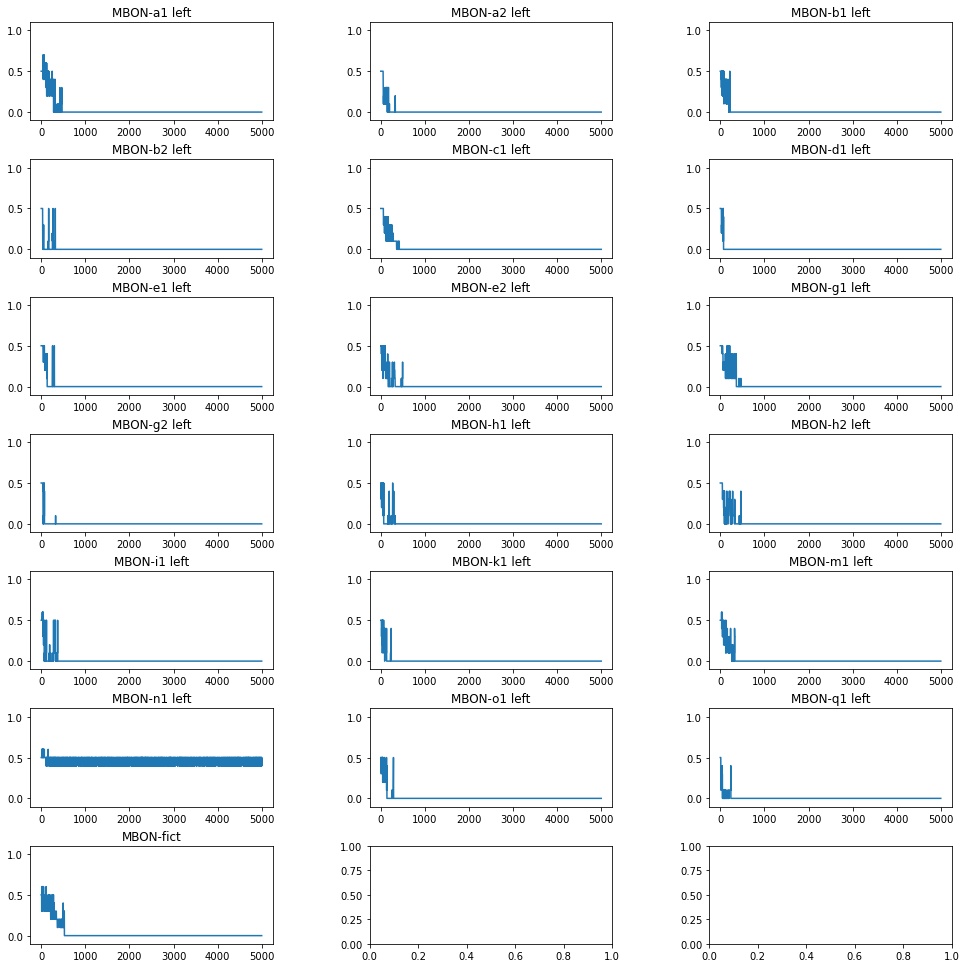

Realization 3: DONE


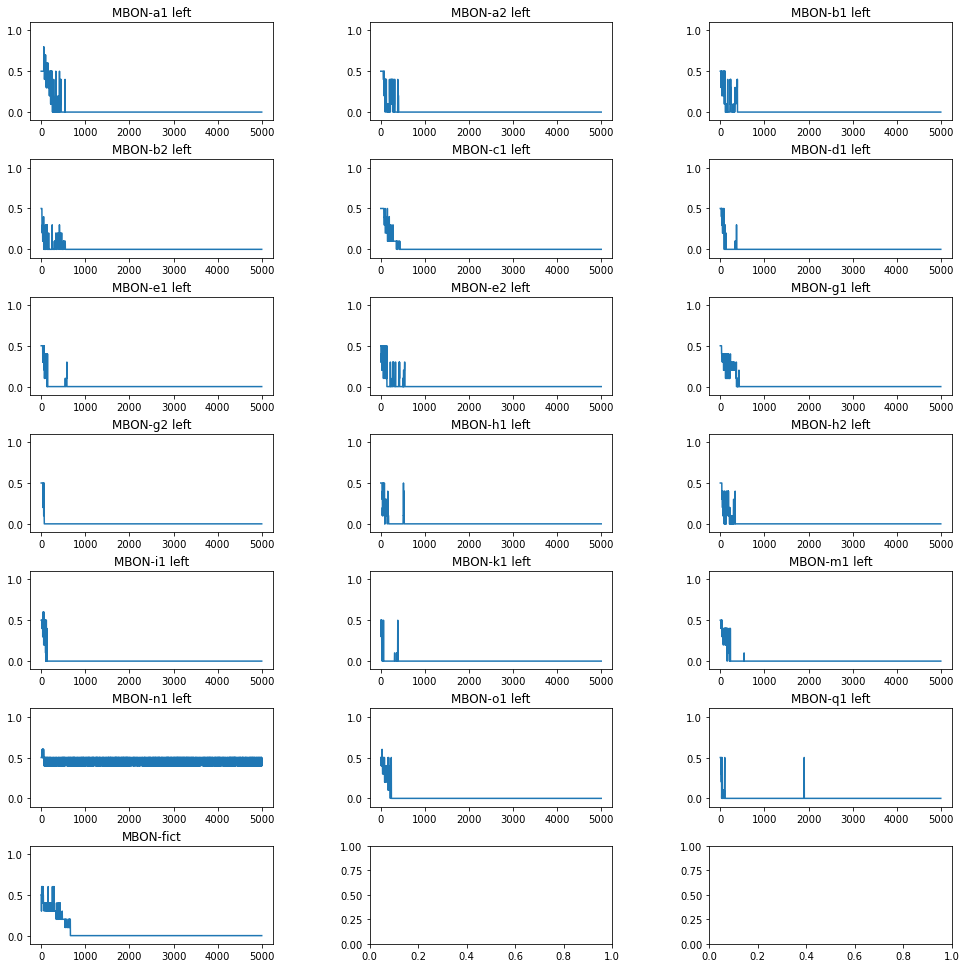

Realization 4: DONE


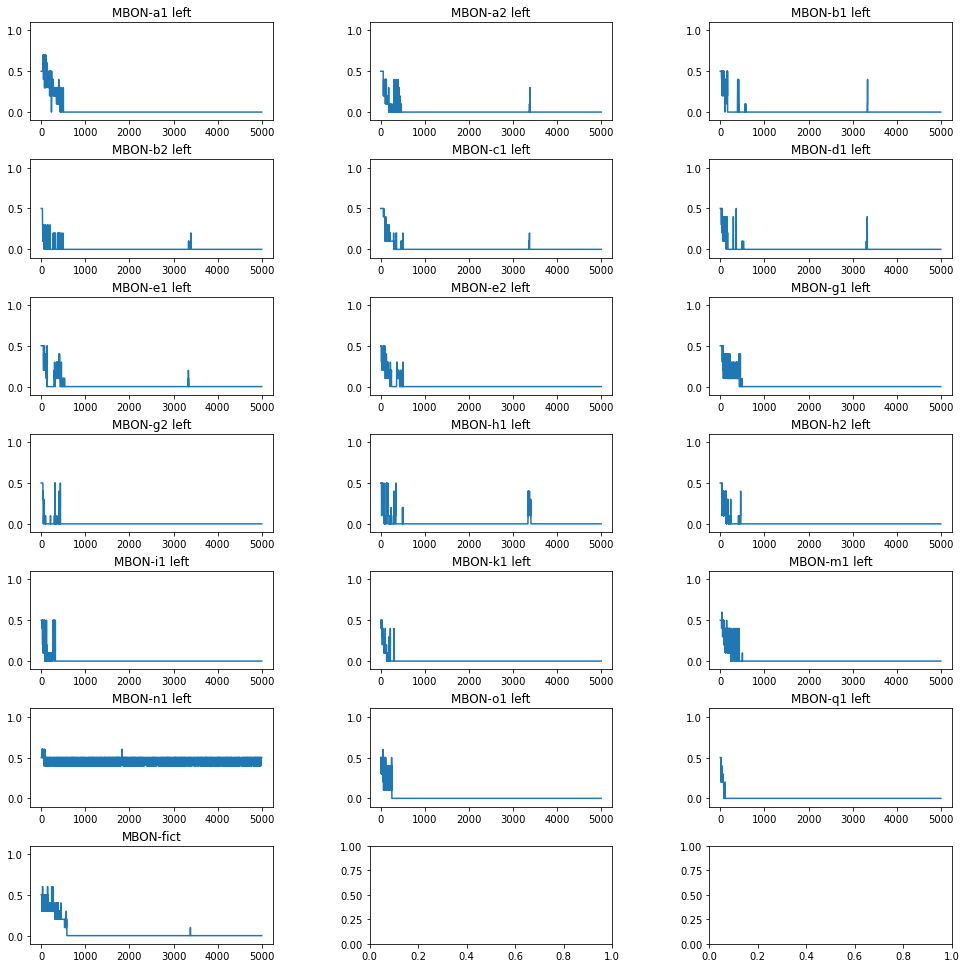

Realization 5: DONE


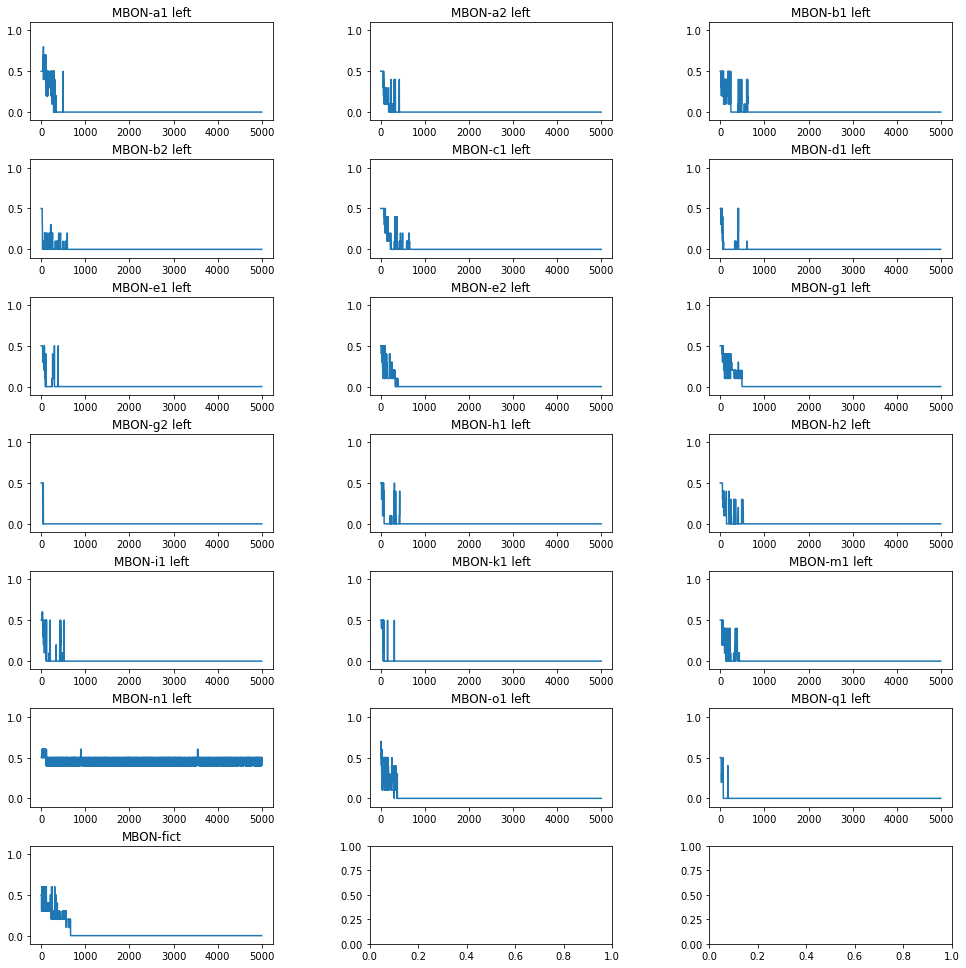

Realization 6: DONE


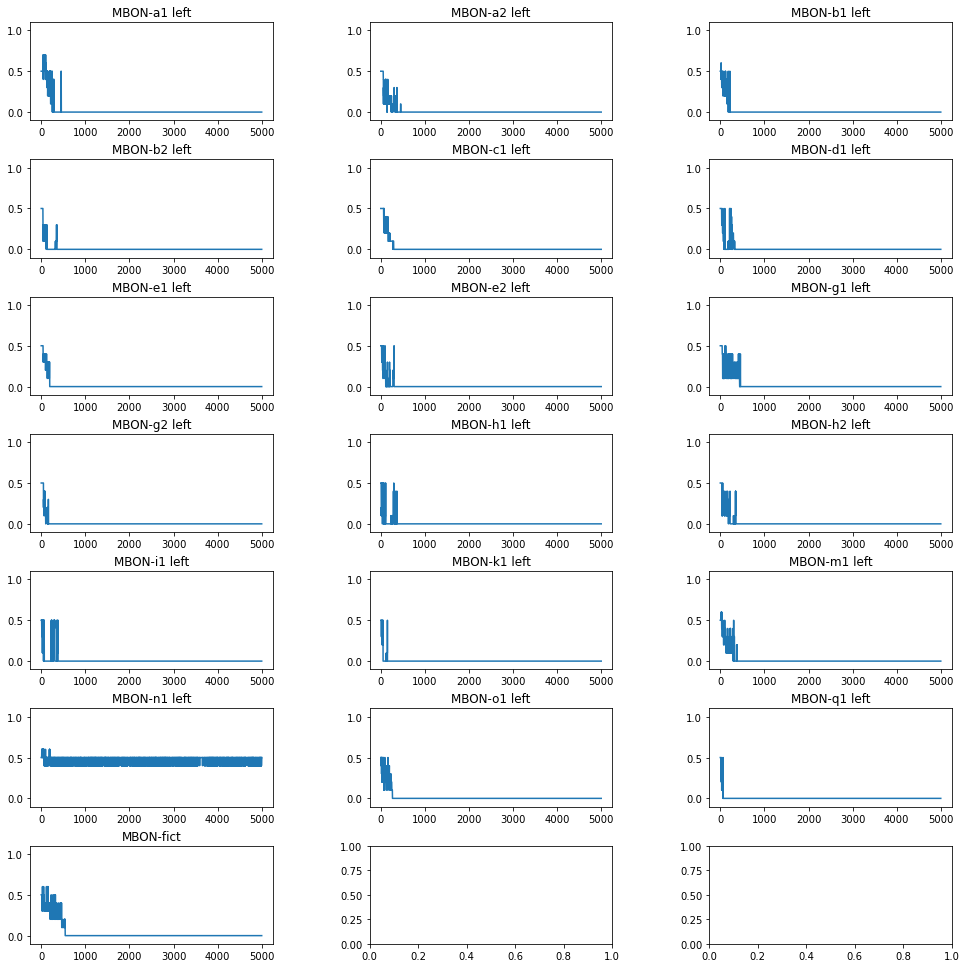

Realization 7: DONE


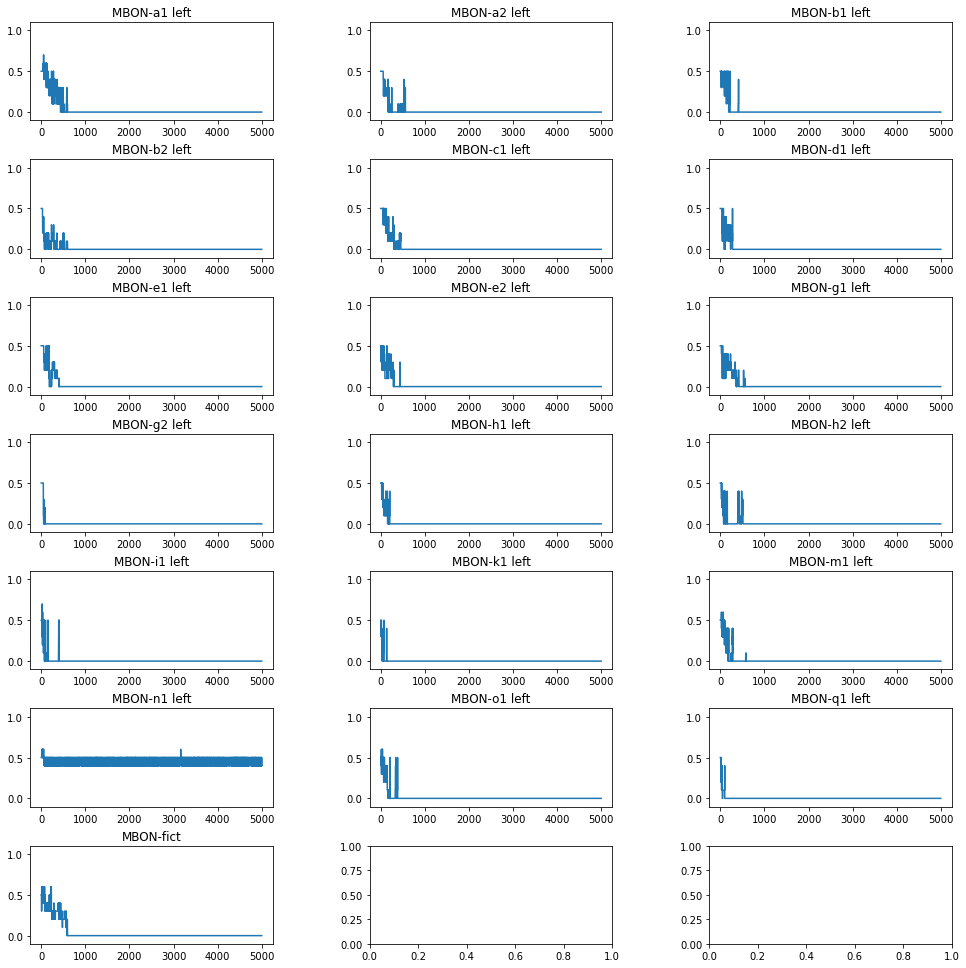

Realization 8: DONE


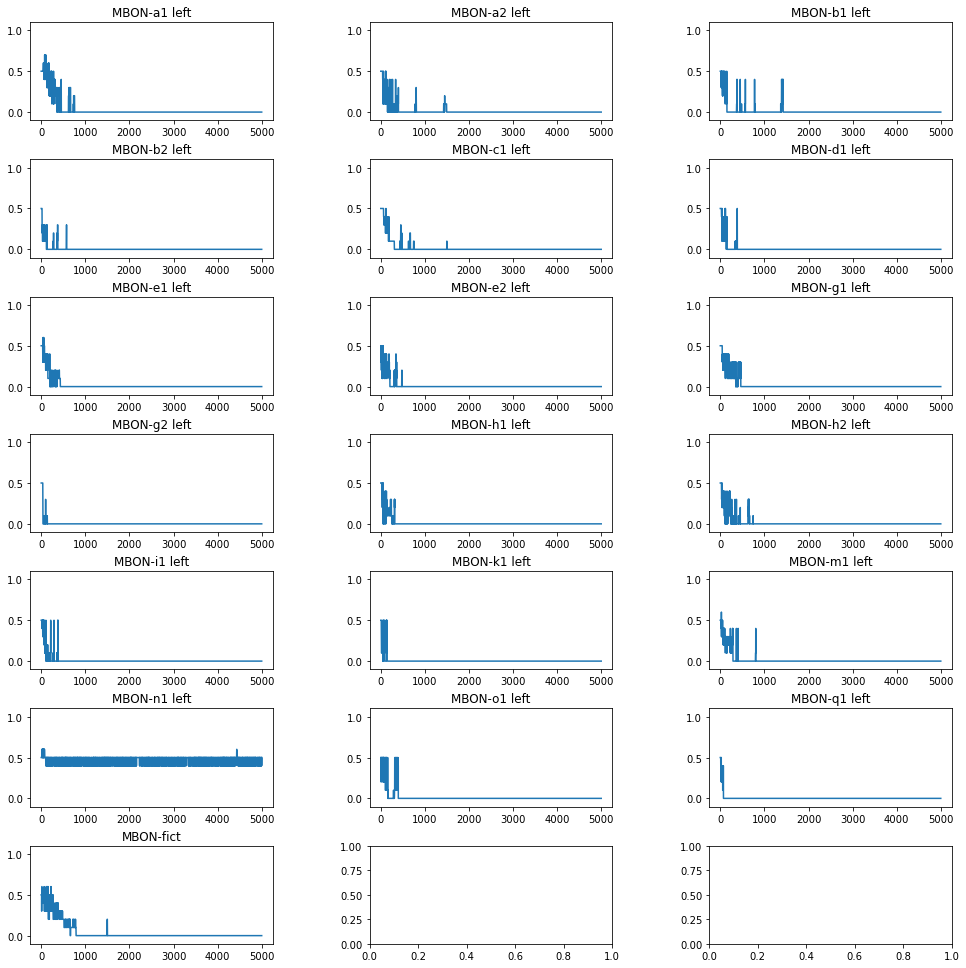

Realization 9: DONE


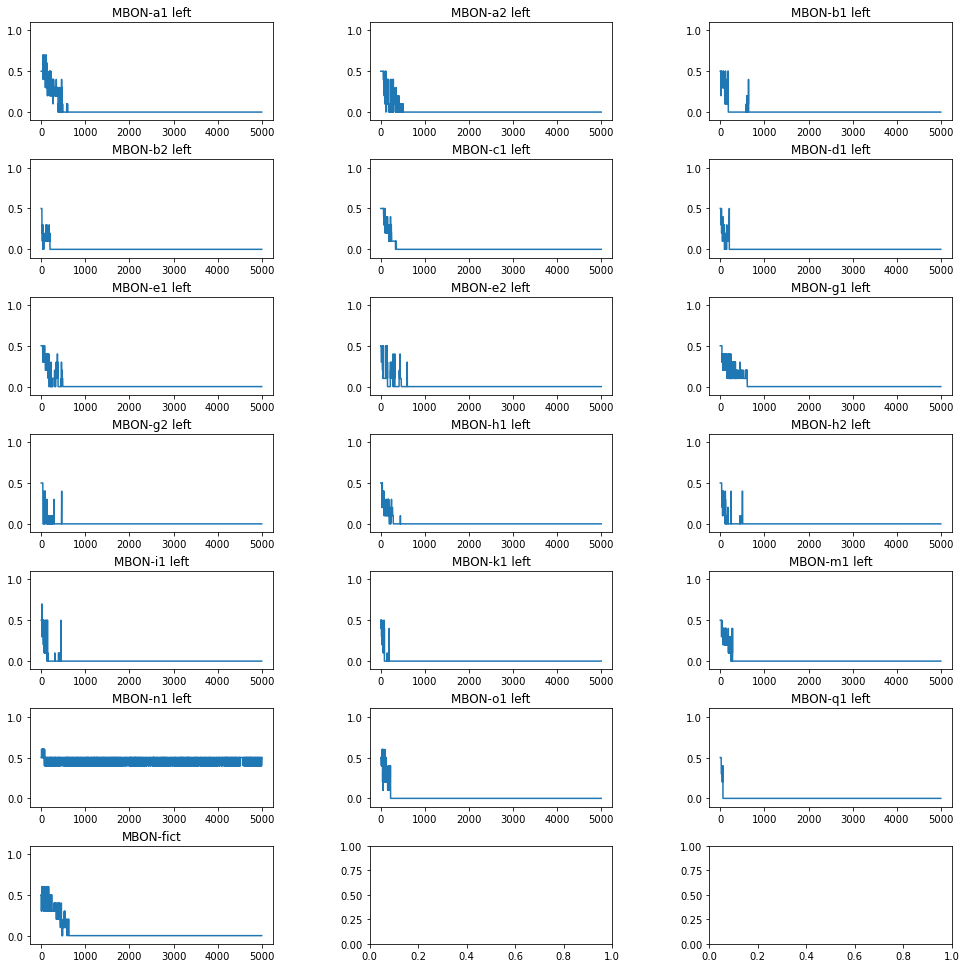

Realization 10: DONE


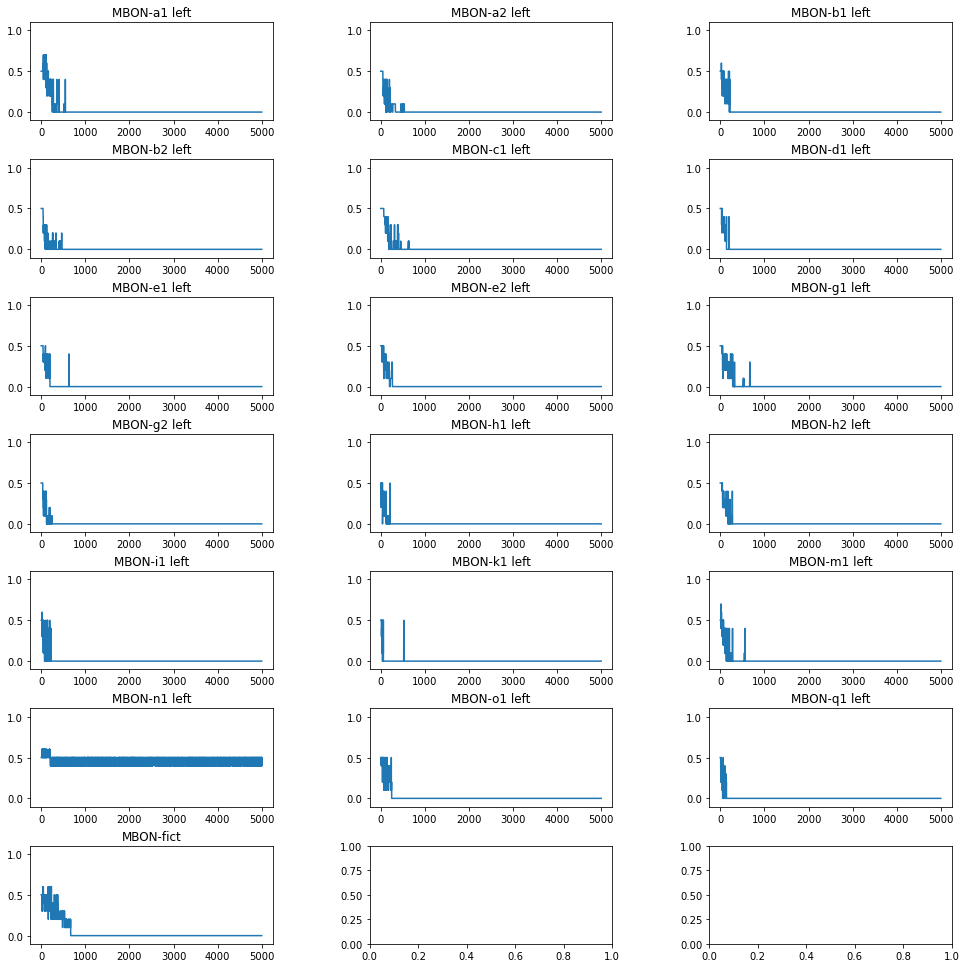

In [15]:
# neuron numbers
num_kcs = len(pn_kc.columns)
num_pns = len(pn_kc) # number of PNs (40), also = number of dimensions of the odor
num_mbons = len(kc_mbon.columns)

num_inputs = 50000 # num of input points
N = 10 # num of odors
T = 5000 # num of time points

# LOOP - RUN THRU MULTIPLE ROUNDS OF TRAINING W/ VARYING INPUT DISTS

R = 10 # number of runs of training 
eta = 0.01 # learning rate

all_error_rates = np.zeros((R, T, num_mbons)) # array to store error rates

all_kc_weights = np.zeros((R, num_kcs, num_mbons)) # array to store all final KC weights for each run
total_weights = np.zeros((R, T, num_kcs, num_mbons)) # array to store all KC weights over time for each realization

all_kc_biases = np.zeros((R, num_kcs)) # array to store KC biases from each run
all_mbon_biases = np.zeros((R, num_mbons)) # array to store MBON biases from each run

time = np.full((R, num_mbons), T+1) # records the time step where error rates for each MBON reached 0.05 or below

input_means = np.zeros((N, num_pns)) # records input distributions for input into network

all_kcs_removed = [[] for _ in range(R)] # stores the names of the KCs removed

# for rerunning with previous odors and removing based on previous weights
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control/input-means1.pkl', 'rb') as f:
    input_means = pickle.load(f)

# with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/control/final-weights7.pkl', 'rb') as f:
#     prev_final_weights = pickle.load(f)

response = input_means

# GENERATING ODORS
# for running with new odors
spikes = 200
# bool_response = np.random.binomial(1, 0.5, (N, num_pns))  # .5 probability - https://journals.physiology.org/doi/full/10.1152/jn.01283.2007   
# probability = np.random.normal(0.8, 0.05, (N, num_pns)) # center, std, size
# response = np.multiply(bool_response, probability)

# record input distributions
# input_means = response

# # for running with same odors
# all_inputs = total_inputs
# pn_inputs = total_inputs_3D

# target outputs for each odor
odor_outputs = np.zeros((N, num_mbons))

# make sure output isn't the same for all odors for each PN
odor_outputs[0] = [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1]
odor_outputs[1] = [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0]
odor_outputs[2] = [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
odor_outputs[3] = [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]
odor_outputs[4] = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
odor_outputs[5] = [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0]
odor_outputs[6] = [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]
odor_outputs[7] = [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]
odor_outputs[8] = [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]
odor_outputs[9] = [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1]

target_outputs = np.full((num_inputs, num_mbons), odor_outputs[0]) # array of target outputs used for training
for i in range(N):
    target_outputs[i*num_inputs//N:] = odor_outputs[i]

# LOOP THRU MULTIPLE RUNS OF TRAINING

for r in range(R):
    
    # generating input points
    all_inputs = np.zeros((num_inputs, num_pns)) # 2D input array used for neural network
    odor_idx = num_inputs//N
    pn_inputs = np.zeros((N, num_inputs//N, num_pns)) # 3D inputs separated by odor
    for n in range(N):
        inputs = np.random.binomial(spikes, response[n], size=(num_inputs//N, num_pns))
        all_inputs[n*odor_idx:odor_idx*(n + 1)] = inputs
        pn_inputs[n] = inputs
        
    # plot input distributions
    if r == 0:
        plt.figure()
        for i in range(N):
            plt.plot(pn_inputs[i, :, 2], pn_inputs[i, :, -3], '.', alpha = 0.2)
        plt.xlim(-5, 200)
        plt.ylim(-5, 200)

        plt.show()
        
    # SET BIAS VALUES FOR KCS
    kc_biases = np.zeros((num_kcs,)) # stores biases for all KCs
    pn_synapses = pn_kc.to_numpy()

    for i in range(num_kcs):
        w = pn_synapses[:, i] # get weights column by column (where columns correspond to # of synapses to each KC)
        kc_biases[i] = set_kc_bias(all_inputs, w)
        
    total_output1 = build_pn_to_kc(all_inputs, pn_synapses, kc_biases) # calculate all outputs of KCs for all input points
    # dimensions: inputs (15000 x 40), weights (40 x 110), biases (1 x 110) -> output (15000 x 110)
    
    # WEIGHTS
    kc_mbon_copy = kc_mbon.copy(deep=True) # weights (synapse table)
    
    # NOT REMOVING ANY WEIGHTS
    weights = kc_mbon_copy.to_numpy()
      
    # SET INITIAL VALUES
    bool_synapses = np.where(weights > 0, 1, 0) # boolean representation of the synaptic weights where an element is 1 if w > 0
    
    biases = np.full((num_mbons,), 0.1) # initialize all biases of MBONS at 0.1

    total_error_rate = np.zeros((T, num_mbons)) # stores percentage of correct outputs for each MBON

    total_output1 = build_pn_to_kc(all_inputs, pn_synapses, kc_biases) # calculate all outputs of KCs for all input points
    # dimensions: inputs (15000 x 40), weights (40 x 110), biases (1 x 110) -> output (15000 x 110)
    
    # LOOP THROUGH INPUTS TO TRAIN MODEL
    for p in range(T):

        # PN -> KC (fixed weights, biases)

        # get random index of input
        index = random.randint(num_inputs)

        # using input to PN layer, get output of KC layer
        output1 = total_output1[index]

        # KC -> MBON (training portion - weights, biases are updated)
        inputs = output1 # inputs taken from output of pn->kc
        output2 = build_kc_to_mbon(inputs, weights, biases)

        # CALCULATE TOTAL ERROR FOR ALL INPUTS
        total_output2 = build_kc_to_mbon(total_output1, weights, biases) # calculate total output of MBONs
        # dimensions: inputs (15000 x 110), weights (110 x 19), biases (1 x 19) -> output (15000 x 19)

        # NOTE: each column of output array represents output of each single MBON for all the inputs
        total_error = target_outputs - total_output2
        # dimensions: target output (15000 x 19), total output MBON (15000 x 19) -> error (15000 x 19)

        total_error_rate[p, :] = 1 - np.sum((total_error == 0), axis=0) / num_inputs # store current error rates
        
        # record when error rate for each MBON reaches a threshold (0.05 or less)
        current_error_rate = total_error_rate[p, :] # gets current error rates for all MBONS
        met_idxs = np.asarray(np.where(current_error_rate <= 0.05)).flatten() # indicies where the error rate meets 0.05 or less
        if len(met_idxs) > 0:
            for i in range(len(met_idxs)):
                idx = met_idxs[i]
                current = time[r, idx]
                if (current == T+1): # only if time step is not already recorded 
                    time[r, idx] = p # record the time step where target error rate was achieved

        # UPDATE VALUES
        error = target_outputs[index] - output2
        
        # record weights for this training step
        total_weights[r, p] = weights
        
        # update weights w/ the delta rule
        deltaw = np.outer(inputs, error) * eta # computes change in weights
        deltaw = np.multiply(deltaw, bool_synapses) # change only existing connections
        weights = weights + deltaw
        weights = normalize_kc_weights_np(weights, 1) # normalize weights

        # update bias w/ the delta rule
        delta_bias = np.multiply(biases, error) * eta # computes change in biases
        biases = biases + delta_bias
    
    print("Realization {}: DONE".format(r+1))
    # PLOT ERROR RATES OVER TIME FOR EACH MBON
    figure, axis = plt.subplots(7, 3, figsize=(16, 16))

    a = 0
    for n in range(6):
        for m in range(3): 
            axis[n, m].plot(total_error_rate[:,a])
            axis[n, m].set_title(kc_mbon.columns[a])
            axis[n, m].set_ylim(-0.1, 1.1)
            a += 1

    axis[6, 0].plot(total_error_rate[:,18])
    axis[6, 0].set_title(kc_mbon.columns[18])
    axis[6, 0].set_ylim(-0.1, 1.1)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()

    # STORE FINAL VALUES
    all_error_rates[r] = total_error_rate # add error rate over time for this run to array that holds all error rates 
    all_kc_weights[r] = weights # add final weight for this run to array of all final weights
    
    all_kc_biases[r] = kc_biases # stores KC biases for each run
    all_mbon_biases[r] = biases # stores final MBON biases for each run

# AVERAGING ERROR RATES ACROSS RUNS
avg_error_rates = np.mean(all_error_rates, axis=0)


In [16]:
# SAVE DATA
# save final set of weights for each run
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/total-weights1.pkl', 'wb') as f:
    pickle.dump(total_weights, f)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/final-weights1.pkl', 'wb') as f:
    pickle.dump(all_kc_weights, f)

# save final set of KC biases for each run
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/final-kc-biases1.pkl', 'wb') as f:
    pickle.dump(all_kc_biases, f)

# save final set of MBON biases for each run
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/final-mbon-biases1.pkl', 'wb') as f:
    pickle.dump(all_mbon_biases, f)

# save error rates over time
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/all-error-rates1.pkl', 'wb') as f:
    pickle.dump(all_error_rates, f)
    
# save time for each MBON to learn
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/target-met-time1.pkl', 'wb') as f:
    pickle.dump(time, f)
    
# save odor means
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/input-means1.pkl', 'wb') as f:
    pickle.dump(input_means, f)
    
# # save input distributions
# with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/control/inputs1.pkl', 'wb') as f:
#     pickle.dump(total_inputs, f)
    
# with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/control/inputs-3D1.pkl', 'wb') as f:
#     pickle.dump(total_inputs_3D, f)
    
# save the names of KCs that were removed
with open('C:/Katherine/Research/experiment-data-v3/10-odors-left/kc-const-control/kcs-removed1.pkl', 'wb') as f:
    pickle.dump(all_kcs_removed, f)